<a href="https://colab.research.google.com/github/premkiran-o7/FHE/blob/main/test_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/premkiran-o7/FHE.git

fatal: destination path 'cryptofhe' already exists and is not an empty directory.


In [ ]:
import pandas as pd

# we use another datasets to demo our Logistic Regression
df = pd.read_csv("/content/FHE/data/breast-cancer.csv")

# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

# swap "diagnosis" and "fractal_dimension_worst" columns
df = swap_columns(df, 'diagnosis', 'fractal_dimension_worst')
df.head()

,id,fractal_dimension_worst,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,diagnosis
0,842302,0.11890,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,M
1,842517,0.08902,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,M
2,84300903,0.08758,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,M
3,84348301,0.17300,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,M
4,84358402,0.07678,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,M


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from torch.autograd import Variable

In [ ]:
# replace "M" with 1 and "B" with 0
df["diagnosis"] = (df["diagnosis"] == "M").astype(int)

In [ ]:
def print_dataset(name, data):
    print('Dataset {}. Shape: {}'.format(name, data.shape))
    print(data[:5])

def scale_dataset(df, overSample=False):
    # split to fetures and diagnostic result
    X = df[df.columns[:-1]].values
    Y = df[df.columns[-1]].values

    # standardize the input features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # balance the class distribution
    if overSample:
        ros = RandomOverSampler()
        X, Y = ros.fit_resample(X, Y)

    data = np.hstack((X, np.reshape(Y, (-1, 1))))

    # convert to tensor context
    X_train_tensor = Variable(torch.tensor(X, dtype = torch.float32))
    Y_train_tensor = Variable(torch.tensor(Y, dtype = torch.float32))
    data_tensor    = Variable(torch.tensor(data, dtype = torch.float32))

    return data_tensor, X_train_tensor, Y_train_tensor

In [ ]:
# split dataframe to train and test df
df_train, df_test = np.split(df.sample(frac=1), [int(0.8 * len(df))])

# scaling and convert to tensor context
train, X_train, Y_train = scale_dataset(df_train, True)
test , X_test , Y_test  = scale_dataset(df_test , False)
train

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


tensor([[-0.2417, -0.2654,  1.0004,  ...,  1.2191,  0.0473,  1.0000],
        [-0.2416, -0.7866, -0.6571,  ..., -0.6199, -1.4919,  1.0000],
        [-0.1779,  0.1913, -0.9582,  ..., -0.4034, -0.4760,  0.0000],
        ...,
        [-0.1795, -1.1502,  1.4736,  ...,  0.9755, -0.7385,  1.0000],
        [-0.2417, -0.6706,  1.8435,  ...,  0.4763, -1.0707,  1.0000],
        [-0.2417,  0.3276,  1.5482,  ...,  1.3093,  0.7780,  1.0000]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class LR(torch.nn.Module):
    def __init__(self, num_features):
        # init super class of LogisticRegression
        super(LR, self).__init__()

        # create "linear neural network"
        input_dim  = num_features
        output_dim = 1
        self.linear = torch.nn.Linear(input_dim, output_dim)

        # initialize Weights and Bias
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [ ]:
input_dim = 31 # numbers of features
epochs = 10000
learning_rate = 0.01

In [ ]:
from tqdm.notebook import tqdm

def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)
to_percent = lambda x: '{:.2f}%'.format(x)

def compute_accuracy(model, input, output):
    prediction = model(input).data.numpy()[:, 0]
    n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction == output.data.numpy()
    return 100. * equal.sum() / n_samples





In [ ]:
def Training(model, X_train, Y_train, X_test, Y_test, debug=True):
    model = model
    n_samples, _ = X_train.shape

    # record losses and accuracies during training
    losses = []
    accuracies = []

    # define criterion function and set up optimizer
    criterion = torch.nn.BCELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # main process
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        #### Compute outputs ####
        prediction = model(X_train)
         #### Compute gradients ####
        loss = criterion(prediction.squeeze(), Y_train)

        loss.backward()

        #### Update weights ####
        optimizer.step()

        #### Logging ####
        if debug and (epoch + 1)%50 == 0:
            # compute accuracy and loss
            train_acc = compute_accuracy(model, X_train, Y_train)
            train_loss = loss.item()
            losses.append(train_loss)
            accuracies.append(train_acc)

            print('[LOG] Epoch: %05d' % (epoch + 1), end="")
            print('    | Train ACC: %s' % to_percent(train_acc), end="")
            print('    | Loss: %.3f' % train_loss)

    recorded = [accuracies, losses]
    return model, recorded

In [ ]:
final_model = LR(num_features=31)

In [ ]:
# training process
final_model, recorded = Training(final_model, X_train, Y_train, X_test, Y_test)

  0%|          | 0/10000 [00:00<?, ?it/s]

[LOG] Epoch: 00050    | Train ACC: 94.98%    | Loss: 0.320
[LOG] Epoch: 00100    | Train ACC: 95.33%    | Loss: 0.245
[LOG] Epoch: 00150    | Train ACC: 95.16%    | Loss: 0.209
[LOG] Epoch: 00200    | Train ACC: 95.50%    | Loss: 0.188
[LOG] Epoch: 00250    | Train ACC: 95.67%    | Loss: 0.173
[LOG] Epoch: 00300    | Train ACC: 96.37%    | Loss: 0.162
[LOG] Epoch: 00350    | Train ACC: 96.37%    | Loss: 0.153
[LOG] Epoch: 00400    | Train ACC: 96.37%    | Loss: 0.146
[LOG] Epoch: 00450    | Train ACC: 96.54%    | Loss: 0.140
[LOG] Epoch: 00500    | Train ACC: 96.54%    | Loss: 0.135
[LOG] Epoch: 00550    | Train ACC: 96.54%    | Loss: 0.131
[LOG] Epoch: 00600    | Train ACC: 96.54%    | Loss: 0.128
[LOG] Epoch: 00650    | Train ACC: 96.54%    | Loss: 0.124
[LOG] Epoch: 00700    | Train ACC: 96.71%    | Loss: 0.122
[LOG] Epoch: 00750    | Train ACC: 96.89%    | Loss: 0.119
[LOG] Epoch: 00800    | Train ACC: 96.89%    | Loss: 0.117
[LOG] Epoch: 00850    | Train ACC: 96.89%    | Loss: 0.1

In [ ]:
print('Model parameters:')
print('  | Weights: %s' % final_model.linear.weight)
print('  | Bias: %s'    % final_model.linear.bias)

Model parameters:
  | Weights: Parameter containing:
tensor([[ 0.1901,  0.3647,  0.5255,  0.4323,  0.5219,  0.5476,  0.2725,  0.0195,
          0.6945,  0.8352, -0.1169, -0.2273,  0.8326,  0.0827,  0.5622,  0.6272,
          0.0278, -0.6398, -0.1074,  0.2330, -0.3793, -0.6283,  0.8311,  0.8644,
          0.7638,  0.7759,  0.7082,  0.2279,  0.7522,  0.8575,  0.3841]],
       requires_grad=True)
  | Bias: Parameter containing:
tensor([-0.1717], requires_grad=True)


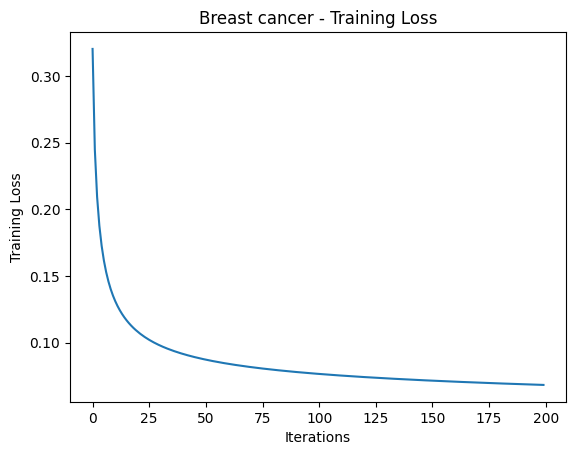

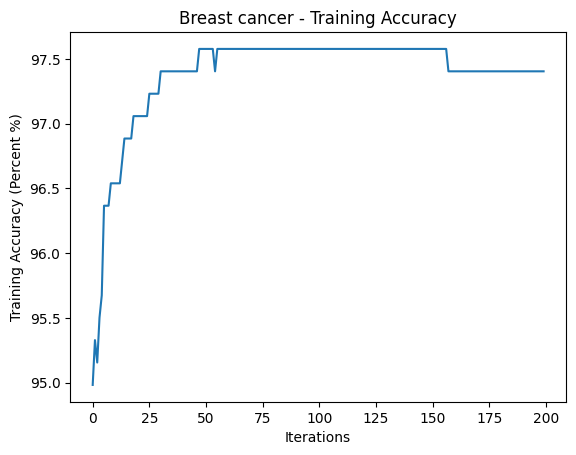

In [ ]:
def plot_graphs(diagnosis_title, record):
    accuracies, losses = record
    plt.plot(losses)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

diagnosis_title = 'Breast cancer'
plot_graphs(diagnosis_title, recorded)

In [ ]:
test_acc = compute_accuracy(final_model, X_test, Y_test)
print('[+] Testing Accuracy = {}'.format(to_percent(test_acc)))

[+] Testing Accuracy = 98.25%


# test

In [ ]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.4 MB/s eta 0:00:00


In [ ]:
import torch
import tenseal as ts
from torch.autograd import Variable
import torch.nn as nn

# Updated Logistic Regression model to support homomorphic encryption
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        input_dim = num_features
        output_dim = 1
        self.linear = torch.nn.Linear(input_dim, output_dim)

        # Initialize weights and bias
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    def encrypt_weights(self, context):
        """
        Encrypts the model's weights and bias using the provided Tenseal context.
        """
        weights = self.linear.weight.data.squeeze().tolist()
        bias = self.linear.bias.data.squeeze().tolist()

        self.encrypted_weights = ts.ckks_vector(context, weights)
        self.encrypted_bias = ts.ckks_vector(context, [bias])

    def decrypt_weights(self):
        """
        Decrypts the model's encrypted weights and bias.
        """
        decrypted_weights = self.encrypted_weights.decrypt()
        decrypted_bias = self.encrypted_bias.decrypt()[0]

        W = Variable(torch.tensor([decrypted_weights], dtype=torch.float32))
        B = Variable(torch.tensor(decrypted_bias, dtype=torch.float32))

        self.linear.weight = nn.Parameter(W)
        self.linear.bias = nn.Parameter(B)





In [ ]:
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.global_scale = 2 ** 40
context.generate_galois_keys()

    # Create and train a local model (example)
num_features = 31  # Example feature size
model = LogisticRegression(num_features)

    # Encrypt model weights for secure transmission
model.encrypt_weights(context)

    # Simulate decryption on the server side after receiving encrypted weights
model.decrypt_weights()

In [ ]:
model.linear.weight

Parameter containing:
tensor([[ 5.3610e-10, -1.9625e-09, -1.7469e-10,  1.2942e-10,  1.1021e-11,
          2.4763e-10,  1.1783e-09, -8.3236e-10, -5.3348e-10,  4.7942e-10,
         -4.0557e-11,  5.9382e-10, -2.3444e-10, -9.3453e-10,  1.5766e-09,
         -6.7072e-10, -1.5791e-09,  9.7738e-10, -1.0477e-09, -3.2358e-10,
         -5.8180e-10,  1.0452e-09, -1.6796e-10,  4.2434e-11,  1.2186e-09,
         -1.8066e-09, -1.0029e-09,  1.7138e-09,  3.9068e-10,  3.4968e-11,
          8.7066e-10]], requires_grad=True)

In [ ]:
final_model, recorded = Training(model, X_train, Y_train, X_test, Y_test)

  0%|          | 0/10000 [00:00<?, ?it/s]

[LOG] Epoch: 00050    | Train ACC: 94.98%    | Loss: 0.320
[LOG] Epoch: 00100    | Train ACC: 95.33%    | Loss: 0.245
[LOG] Epoch: 00150    | Train ACC: 95.16%    | Loss: 0.209
[LOG] Epoch: 00200    | Train ACC: 95.50%    | Loss: 0.188
[LOG] Epoch: 00250    | Train ACC: 95.67%    | Loss: 0.173
[LOG] Epoch: 00300    | Train ACC: 96.37%    | Loss: 0.162
[LOG] Epoch: 00350    | Train ACC: 96.37%    | Loss: 0.153
[LOG] Epoch: 00400    | Train ACC: 96.37%    | Loss: 0.146
[LOG] Epoch: 00450    | Train ACC: 96.54%    | Loss: 0.140
[LOG] Epoch: 00500    | Train ACC: 96.54%    | Loss: 0.135
[LOG] Epoch: 00550    | Train ACC: 96.54%    | Loss: 0.131
[LOG] Epoch: 00600    | Train ACC: 96.54%    | Loss: 0.128
[LOG] Epoch: 00650    | Train ACC: 96.54%    | Loss: 0.124
[LOG] Epoch: 00700    | Train ACC: 96.71%    | Loss: 0.122
[LOG] Epoch: 00750    | Train ACC: 96.89%    | Loss: 0.119
[LOG] Epoch: 00800    | Train ACC: 96.89%    | Loss: 0.117
[LOG] Epoch: 00850    | Train ACC: 96.89%    | Loss: 0.1

# Federated Learning

In [ ]:
class Client:
    def __init__(self, name, data_url, n_features, iters):
        self.id = name

        # split data into train and test
        self.X_train, self.Y_train, self.X_test, self.Y_test = self.preprocessing(data_url)

        # define local training model
        self.local_model = LogisticRegression(n_features)

        # some helpful utilities
        self.decide_vectorized = np.vectorize(self.decide)
        self.to_percent = lambda x: '{:.2f}%'.format(x)
        self.num_epochs = iters
        self.accuracies = []
        self.losses = []

    def preprocessing(self, data_url):
        df = pd.read_csv(data_url)
        # Replace "M" with 1 and "B" with 0 in the "diagnostic" column
        df["diagnostic"] = (df["diagnostic"] == "M").astype(int)

        # split dataframe into train and test sets
        df_train, df_test = np.split(df.sample(frac=1), [int(0.8 * len(df))])

        # scaling and convert to tensor
        train, X_train, Y_train = scale_dataset(df_train, True)
        test, X_test, Y_test = scale_dataset(df_test, False)
        return X_train, Y_train, X_test, Y_test

    def decide(self, y):
        return 1. if y >= 0.5 else 0.

    def compute_accuracy(self, input, output):
        prediction = self.local_model(input).data.numpy()[:, 0]
        n_samples = prediction.shape[0] + 0.
        prediction = self.decide_vectorized(prediction)
        equal = prediction == output.data.numpy()
        return 100. * equal.sum() / n_samples

    def local_training(self, debug=True):
        n_samples, _ = self.X_train.shape

        # define criterion function and set up optimizer
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.SGD(self.local_model.parameters(), lr=0.01)

        # main process
        for epoch in range(self.num_epochs):
            optimizer.zero_grad()
            #### Compute outputs ####
            prediction = self.local_model(self.X_train)

            #### Compute gradients ####
            loss = criterion(prediction.squeeze(), self.Y_train)
            loss.backward()

            #### Update weights ####
            optimizer.step()

            # compute accuracy and loss
            train_acc = self.compute_accuracy(self.X_train, self.Y_train)
            train_loss = loss.item()

            self.losses.append(train_loss)
            self.accuracies.append(train_acc)

            #### Logging ####
            if debug and (epoch + 1) % 50 == 0:
                print('[LOG] Epoch: %05d' % (epoch + 1), end="")
                print('    | Train ACC: %s' % self.to_percent(train_acc), end="")
                print('    | Loss: %.3f' % train_loss)

    def encrypted_model_params(self, context):
        """
        Encrypts the model parameters using CKKS vectors .
        """
        self.local_model.encrypt_weights(context)




    def decrypted_model_params(self):
        """
        Decrypt the model parameters and update the local model.
        """
        self.local_model.decrypt_weights()

    def plot_graphs(self, diagnosis_title='Breast cancer'):
        plt.plot(self.losses)
        plt.title(f"{diagnosis_title} - Training Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Training Loss")
        plt.show()
        plt.plot(self.accuracies)
        plt.title(f"{diagnosis_title} - Training Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Training Accuracy (Percent %)")
        plt.show()

    def print_result_after_training(self):
        print('Model parameters:')
        print('  | Weights: %s' % self.local_model.linear.weight)
        print('  | Bias: %s' % self.local_model.linear.bias)
        self.plot_graphs()

    def evaluating_model(self):
        test_acc = self.compute_accuracy(self.X_test, self.Y_test)
        print('[+] Testing Accuracy = {}'.format(self.to_percent(test_acc)))


In [ ]:
def compute_federated_accuracy(model, input, output):
    """
    Compute the accuracy of the global model on the given input and output data.
    """
    prediction = model(input)
    n_samples = prediction.shape[0]
    correct_predictions = 0.0

    for i in range(n_samples):
        predicted_label = 1.0 if prediction[i] >= 0.5 else 0.0
        correct = 1.0 if predicted_label == output[i] else 0.0
        correct_predictions += correct

    return 100.0 * correct_predictions / n_samples


def aggregator(clients):
    """
    Aggregates encrypted model parameters from all clients using homomorphic operations.
    """
    aggregated_weights = None
    aggregated_bias = None
    n_clients = len(clients)

    # Collect encrypted parameters from all clients
    for i, client in enumerate(clients):
        context = client.local_model.encrypted_weights.context
        enc_weights = client.local_model.encrypted_weights
        enc_bias = client.local_model.encrypted_bias

        if i == 0:
            aggregated_weights = enc_weights
            aggregated_bias = enc_bias
        else:
            aggregated_weights += enc_weights
            aggregated_bias += enc_bias

    # Average the parameters by multiplying with the reciprocal of the number of clients
    scale_factor = 1.0 / n_clients
    aggregated_weights *= scale_factor
    aggregated_bias *= scale_factor

    # Update global model with aggregated parameters
    global_model = LogisticRegression(clients[0].local_model.linear.in_features)
    global_model.linear.weight = nn.Parameter(torch.tensor([aggregated_weights.decrypt()], dtype=torch.float32))
    global_model.linear.bias = nn.Parameter(torch.tensor(aggregated_bias.decrypt(), dtype=torch.float32))

    return global_model


def federated_learning(clients, context, iterations=1000, worker_iterations=5):
    """
    Perform federated learning across multiple clients.
    """
    # Initialize global training model
    global_model = LogisticRegression(clients[0].local_model.linear.in_features)

    # Record losses and accuracies from clients
    losses = [[] for _ in clients]
    accuracies = [[] for _ in clients]

    pbar = tqdm(range(iterations), desc='Federated Learning Process')
    for iteration in pbar:
        if iteration > 0:
            # Decrypt client model parameters and update the global model
            for client in clients:
                client.decrypted_model_params()

        # Perform local training for each client and report accuracy/loss
        for i, client in enumerate(clients):
            client.local_training(debug=False)
            losses[i].append(client.losses[-1])
            accuracies[i].append(client.accuracies[-1])

        # Encrypt and save client parameters for aggregation
        for client in clients:
            client.encrypted_model_params(context)

        # Aggregate parameters using homomorphic encryption
        global_model = aggregator(clients)

        # Logging progress
        if (iteration + 1) % 100 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(len(clients))]
            accuracies_str = ['{:.2f}%'.format(accuracies[i][-1]) for i in range(len(clients))]
            print(f'[LOG] Epoch {iteration + 1:04d} | Losses: {losses_str} | Accuracies: {accuracies_str}')

    return losses, accuracies


In [ ]:
clients = [
    Client('Hostpital1', '/content/FHE/data/dataset1.csv',  n_features=31, iters=10),
    Client('Hostpital2', '/content/FHE/data/dataset2.csv',  n_features=31, iters=10),
    Client('Hostpital3', '/content/FHE/data/dataset3.csv',  n_features=31, iters=10),
    Client('Hostpital4', '/content/FHE/data/dataset4.csv',  n_features=31, iters=10)
]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
iterations = 1000 #2000
worker_iterations = 5
to_percent = lambda x: '{:.2f}%'.format(x)
n_hospitals = len(clients)
n_features = 31

In [ ]:
losses, accuracies = federated_learning(clients, context=context)

Federated Learning Process:   0%|          | 0/1000 [00:00<?, ?it/s]

[LOG] Epoch 0100 | Losses: ['0.0660', '0.0503', '0.0594', '0.0746'] | Accuracies: ['98.21%', '99.08%', '98.47%', '97.73%']
[LOG] Epoch 0200 | Losses: ['0.0511', '0.0352', '0.0454', '0.0572'] | Accuracies: ['98.51%', '99.18%', '98.88%', '98.01%']
[LOG] Epoch 0300 | Losses: ['0.0445', '0.0289', '0.0392', '0.0490'] | Accuracies: ['98.41%', '99.18%', '99.08%', '98.30%']
[LOG] Epoch 0400 | Losses: ['0.0405', '0.0252', '0.0356', '0.0440'] | Accuracies: ['98.71%', '99.18%', '99.18%', '98.30%']
[LOG] Epoch 0500 | Losses: ['0.0379', '0.0227', '0.0331', '0.0406'] | Accuracies: ['98.81%', '99.49%', '99.29%', '98.30%']
[LOG] Epoch 0600 | Losses: ['0.0359', '0.0209', '0.0313', '0.0380'] | Accuracies: ['98.81%', '99.49%', '99.29%', '98.58%']
[LOG] Epoch 0700 | Losses: ['0.0344', '0.0194', '0.0299', '0.0360'] | Accuracies: ['98.81%', '99.49%', '99.29%', '98.58%']
[LOG] Epoch 0800 | Losses: ['0.0331', '0.0183', '0.0288', '0.0343'] | Accuracies: ['98.91%', '99.49%', '99.39%', '98.58%']
[LOG] Epoch 0900

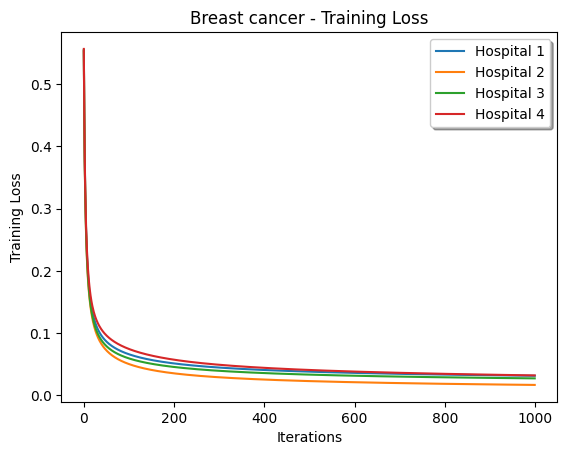

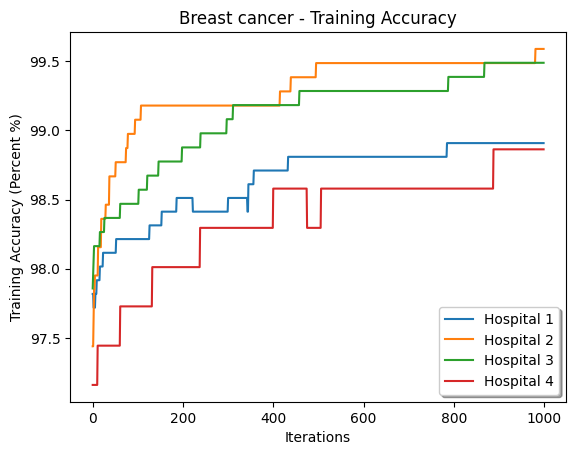

In [ ]:
def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i+1}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i+1}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

plot_federated_graphs('Breast cancer', losses, accuracies)

In [ ]:
clients[0].decrypted_model_params()
global_model = clients[0].local_model

print('\nModel parameters:')
print('  | Weights: %s' % global_model.linear.weight) ### Virtualize record of training processlobal_model.linear.weight)
print('  | Bias: %s' % global_model.linear.bias)


Model parameters:
  | Weights: Parameter containing:
tensor([[-0.6764,  0.7298,  0.0886,  0.7726,  0.6163,  0.1848,  0.2080,  0.6061,
          0.7069,  0.0388, -0.5302,  0.5603, -0.4750,  0.4938,  0.6364, -0.1272,
         -0.0898, -0.0058,  0.3635, -0.2502, -0.4147,  0.8207,  0.3737,  0.9078,
          0.8283,  0.2066,  0.5275,  0.2910,  0.6791,  0.5522,  0.2020]],
       requires_grad=True)
  | Bias: Parameter containing:
tensor(0.6743, requires_grad=True)


In [ ]:
# prepare data for testing model
df_test = pd.read_csv('/content/cryptofhe/data/test.csv')
df_test["diagnostic"] = (df_test["diagnostic"] == "M").astype(int)
test , X_test , Y_test  = scale_dataset(df_test , False)

test_acc = compute_federated_accuracy(global_model, X_test, Y_test)
print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))


Testing Accuracy = 89.80%
